In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import evalugator
import evalugator.api
import evalugator.api.dispatcher
import evalugator.api.requests

# note: types from yaml files are represented in `evalugator.structs`, likely only YAML for non-python use cases

In [5]:
# list available providers
print('Available providers:')

# note: these are literal python modules
for provider_module in evalugator.api.dispatcher.PROVIDERS:
    print(f' - {provider_module.__name__}')

Available providers:
 - evalugator.api.providers.openai
 - evalugator.api.providers.anthropic
 - evalugator.api.providers.replicate
 - evalugator.api.providers.human
 - evalugator.api.providers.together_api


In [6]:
assert not evalugator.api.providers.openai.provides_model('foo')
assert evalugator.api.providers.openai.provides_model('gpt-4o')

Note: The way `evalugator.api.dispatcher` works is:

```python
from functools import partial

from .providers import openai, anthropic, replicate, human, together_api

PROVIDERS = [openai, anthropic, replicate, human, together_api]

# note: also checks that model ID only matches exactly one provider
def get_model_provider(model_id):
    providers = []
    for provider in PROVIDERS:
        if provider.provides_model(model_id):
            return provider

def get_request_processor(request, model_id):
    provider = get_model_provider(model_id)
    return partial(provider.execute, model_id)


def encode(model_id, *args, **kwargs):
    provider = get_model_provider(model_id)
    return provider.encode(model_id, *args, **kwargs)


def decode(model_id, *args, **kwargs):
    provider = get_model_provider(model_id)
    return provider.decode(model_id, *args, **kwargs)
```

In [7]:
# this means the implicit provider API is:

from typing import Protocol, ParamSpec

P = ParamSpec('P')

# note: this could be a module or class
class Provider(Protocol):
    def provides_model(self, model_id: str) -> bool:
        ...
    def execute(self, model_id: str, request: evalugator.api.requests.Request) -> evalugator.api.requests.Response:
        ...
    def encode(self, model_id: str, *args: P.args, **kwargs: P.kwargs) -> str:
        ...
    def decode(self, model_id: str, *args: P.args, **kwargs: P.kwargs) -> str:
        ...

This then allows the `API` to be used like this:

```python
class API:
    
    model_id: str
    executor: ThreadPoolExecutor

    # note: allows automatically saving results, essentially poor man's async, which makes since given not all providers might have async
    def execute(self, request: Request) -> Future[Response]:
        func = dispatcher.get_request_processor(request, self.model_id)
        future = self.executor.submit(func, request)
        future.add_done_callback(self._log_response)
        return future

    def encode(self, *args, **kwargs):
        return dispatcher.encode(self.model_id, *args, **kwargs)

    def decode(self, *args, **kwargs):
        return dispatcher.decode(self.model_id, *args, **kwargs)
```

additionally defines two convenience functions:

```python
    def get_text(self, ...) -> Future[GetTextResponse]:
        request = GetTextRequest(...)
        return self.execute(request)
    
    def get_probs(self, ...) -> Future[GetPropsResponse]:
        request = GetProbsRequest(...)
        return self.execute(request)
```

In [8]:
model_id = 'gpt-4o-mini'

# note: also allows `log_file_name`
api = evalugator.api.Api(model_id=model_id)

response_future = api.get_text(prompt='Hi!')

# actual waiting
response = response_future.result()

response

GetTextResponse(model_id='gpt-4o-mini', request=GetTextRequest(context=None, prompt=[Message(role='user', content='Hi!')], temperature=1, max_tokens=512), raw_responses=[ChatCompletion(id='chatcmpl-9y7CeaNPkZ7jesyuUlNBAOdyhKy1B', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1724114396, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_48196bc67a', usage=CompletionUsage(completion_tokens=9, prompt_tokens=9, total_tokens=18))], context=None, txt='Hello! How can I assist you today?')

In [10]:
response.as_dict()

{'model_id': 'gpt-4o-mini',
 'request': {'context': None,
  'prompt': [{'role': 'user', 'content': 'Hi!'}],
  'temperature': 1,
  'max_tokens': 512},
 'txt': 'Hello! How can I assist you today?',
 'context': None}

In [85]:
# we'll make a new provider with tool use
from typing import Callable, Any
import dataclasses

from gpt_from_scratch.evals.function_calling.openai.function_call_handler import FunctionCallHandler

import openai



# note: task-standard/workbench/example-agents/fncall-baseline/commands.py
#       uses a `return` tool, which seems like an interesting technique

# note: subset of https://github.com/LRudL/evalugator/blob/main/evalugator/api/providers/openai.py#L15
#       that we care about that also supports tool use (not intended to be comprehensive)
#
# note: we can't just use `gpt-4o` etc directly since conflicts with the `openai` provider
_MODEL_ID_TO_MODEL_NAME: dict[str, str] = {
    f'function-calling-{model_name}': model_name
    for model_name in ["gpt-4o", "gpt-4o-mini"]
}

class MaxIterationsReachedError(Exception):
    pass

# TODO(bschoen): Might use `partial` here, since otherwise this is super inefficient
# TODO(bschoen): This really seems like it can only support single turn
# TODO(bschoen): Should we have a custom tool request message?
class OpenAIFunctionCallingProvider(Provider):
    """
    Individual instance of a provider supporting the specified functions.

    Example:
        import evalugator.api.dispatcher
    
        # we'll create a provider customized to have our tools
        provider = OpenAIFunctionCallingProvider(functions=[get_location, get_weather])

        evalugator.api.dispatcher.PROVIDERS.append(provider)

    """

    # note: it's actually fine for this to be stateful, but this whole design is a bit weird
    #       when it comes to customization points for the provider itself when it comes
    #       to provider specific things (which I guess is to be expected)
    #
    #       the provider itself essentially needs to be customizable, and capable of holding
    #       some immutable state, but not mutable per execution?
    def __init__(self, functions: list[Callable[..., Any]], max_iterations_per_execution: int = 3) -> None:

        self._function_call_handler = FunctionCallHandler(functions=functions)
        
        # number of times to hand control back to the model after providing the result of a tool
        self._max_iterations_per_execution = max_iterations_per_execution

        # initialize client
        self._client = openai.OpenAI()

    def _get_model_name(self, model_id: str) -> str:
        return _MODEL_ID_TO_MODEL_NAME[model_id]

    def provides_model(self, model_id: str) -> bool:
        return any(model_id.startswith(prefix) for prefix in _MODEL_ID_TO_MODEL_NAME)
    
    def encode(self, model_id: str, *args: P.args, **kwargs: P.kwargs) -> str:
        return evalugator.api.providers.openai.encode(model_id, *args, **kwargs)
    
    def decode(self, model_id: str, *args: P.args, **kwargs: P.kwargs) -> str:
        return evalugator.api.providers.openai.decode(model_id, *args, **kwargs)
    
    # note: I guess response needs to contain all messages for future request? The
    #       `message` class isn't flexible enough to hold actual history though,
    #       so it seems like this thing overall isn't designed for multi-turn
    def execute(self, model_id: str, request: evalugator.api.requests.Request,) -> evalugator.api.requests.Response:


        print('Executing function calling provider...')
        
        # list of {'role': ..., 'content': ...}
        messages = [dataclasses.asdict(x) for x in request.prompt]

        for i in range(self._max_iterations_per_execution):

            iteration_count = i + 1

            print(f'Attempt {iteration_count} / {self._max_iterations_per_execution}')

            # TODO(bschoen): Schemas actually _can_ contain nested types, if they're pydantic
            #                or dataclasses can support that easily, but description gets annoying,
            #                note that's for the input though.
            # TODO(bschoen): Response format is extremely valuable, can allow specifying it too
            # Note: Can't use response_format, structured_output, and parallel function calling together
            print('Creating completion...')
            response: openai.ChatCompletion = self._client.chat.completions.create(
                model=self._get_model_name(model_id),
                messages=messages,
                tools=self._function_call_handler.get_schema_for_tools_arg(),
            )

            # add message to history (true for both content and tool)
            assert len(response.choices) == 1
            
            choice: openai.types.CompletionChoice = response.choices[0]
            message: openai.types.chat.ChatCompletionMessage = choice.message
            
            messages.append(message.dict())
    
            # show any model text responses
            if message.content:
                print(f'Model response: {message.content}')
        
            # resolve any tool calls
            if message.tool_calls:

                print(f'Processing {len(message.tool_calls)} tool calls')
                
                for tool_call in message.tool_calls:
            
                    print(f'Resolving tool call in response: {tool_call.id}')
                    # print(f'Calling {tool_call.function.name} with args: {tool_call.function.arguments}')
                    tool_call_result_message = self._function_call_handler.resolve(tool_call=tool_call)

                    # print(f"Tool call result: {tool_call_result_message['content']}")
            
                    # add tool call result
                    print(f'Providing results from tool calls back to model...')
                    messages.append(tool_call_result_message)

            # otherwise, no tool calls left to resolve and we can return control back to the user
            else:
                print('\n---\nNo more tool calls left to resolve, breaking')

                # model_solution = messages[-1]['content']

                # print in case isn't valid json
                # print(f'Model solution: `{model_solution}`')
                
                # TODO(bschoen): could put parsed response_format in `context`
                # parse into dedicated struct
                # model_problem_solving_status = ModelProblemSolvingStatus.parse_raw(model_solution)

                return evalugator.api.requests.Response(
                    model_id=model_id,
                    request=request,
                    raw_responses=messages,
                    context=None,
                )

        # if we reach this point we've exhausted max iterations
        raise MaxIterationsReachedError(f'Exhausted max attempts: {self._max_iterations_per_execution}')

    
    

We can now start looking at the eval input / output structure

### Samples

```python
class Sample(pydantic.BaseModel):
    id: str
    splits: Dict[str, str] = {}
    comments: Optional[str] = None
    scores: Dict[ScorerName, Score] = {}
    type: str = "Sample"
    extra_template_vars: dict = {}
    created_by: str = "unknown"

class CustomSample(Sample):
    data: Any
    type: str = "Custom"


class Question(Sample):
    body: Union[str, Prompt]
    type: str = "Question"


class QA(Question):
    ideal_answers: List[str]
    type: str = "QA"


class MCQuestion(Question):
    choices_right: List[str]
    choices_wrong: List[str]
    choices_order: List[str] | None = None
    type: str = "MCQuestion"
```

### Answer Details

```python
# answer info classes (specifying the details of what the correct answers are,
# and how any correct answers got formatted during the render process)

class RenderInfo(BM):
    pass

class QuestionRenderInfo(RenderInfo):
    pass

class QARenderInfo(QuestionRenderInfo):
    ideal_answers: List[str]

class MCQRenderInfo(QuestionRenderInfo):
    ideal_answers: List[str]
    wrong_answers: List[str]
    answer_styles_accepted: List[str]
    text_accepted: bool
    style_default: str
    position_to_answer_text: Dict[int, str]
    position_to_correct: Dict[int, bool]
    position_to_answer_option: Dict[int, str]
```

### Rendered Sample

```python
# There's some weirdness with how Pydantic handles inheritance, so we need to
# explicitly allow every type of sample; let's define a helper for that:
SampleDataTypes = Union[MCQuestion, QA, Question, Sample, CustomSample]
RenderInfoTypes = Union[MCQRenderInfo, QARenderInfo, QuestionRenderInfo, RenderInfo]

class RenderedSample(pydantic.BaseModel):
    typestr: str
    answer_info: Optional[RenderInfoTypes] = None
    sample: SampleDataTypes
    renderer: str | Callable
    parser: str | Callable

```

In [132]:
samples[0]

MathQA(id="id=SolvedProblem(problem='((2 - (7 ** 2)) + 4)', max_problem_depth=3, solution=-43)", splits={}, comments=None, scores={}, type='QA', extra_template_vars={}, created_by='unknown', body=[Message(role='system', content='\nRespond ONLY with the answer to the given arithmetic problem.\n\nExample:\n\n<user_input>\n(((2 - 4) - (6 / 3)) + ((1 ** 2) * 3))\n</user_input>\n\n<assistant_output>\n-1.0\n</assistant_output>\n'), Message(role='user', content='Problem: ((2 - (7 ** 2)) + 4)')], ideal_answers=['-43'], solved_problem=SolvedProblem(problem='((2 - (7 ** 2)) + 4)', max_problem_depth=3, solution=-43))

### Templates

```python
class Template(pydantic.BaseModel):
    id: str
    type: str = "Template"

class SampleTemplate(Template):
    type: str = "SampleTemplate"
    prompt_template: Union[List[Message], str]
    request_args: dict[str, Any] = {}

class QATemplate(SampleTemplate):
    type: str = "QATemplate"
```

### Eval Spec

```python
def get_eval_spec(
    sample_source: list[Sample] | Pile | list[Batch] | Batch,
    id: str | None = None,
    template: SampleTemplateTypes | None = None,
    extensions: list[TemplateExtension] = [],
    templates_container: SampleTemplates | None = None,
    extensions_container: TemplateExtensions | None = None,
    parser: str = "default",
    renderer: str = "default",
) -> _SimpleEvalSpec:
    """
    This is the function to use if you want to create an EvalSpec WITHOUT
    TOUCHING FILES. It skips all evalugator file lookups. Therefore, you must
    also pass things into it as objects, not as id strings. If things are none,
    the defaults are fetched from vars.py, not from any template file. This is
    the final stage of render spec creation for other EvalSpec-returning
    functions, and what you should use on its own if you want to use evalugator
    free of any files.
    """
```

without templates and renderers this makes sense:

```python
@dataclass
class _RenderSettings(Generic[TSampleTemplate]):
    template: TSampleTemplate
    extensions: list[TemplateExtension]  # = field(default_factory=list)
    templates_container: SampleTemplates
    extensions_container: TemplateExtensions
    renderer: str | Callable = "default"
    parser: str | Callable = "default"


@dataclass(kw_only=True)
class _BaseEvalSpec(Generic[TSample, TSampleTemplate]):
    id: str = "unnamed_eval"
    samples: Sequence[TSample]
    sample_origin: str | None = None


class BaseEvalSpec(Template):
    type: str = "BaseEvalSpec"


@dataclass(kw_only=True)
class _SimpleEvalSpec(_BaseEvalSpec[TSample, TSampleTemplate]):
    render_settings: _RenderSettings[TSampleTemplate]


class SimpleEvalSpec(BaseEvalSpec):
    render_settings: RenderSettings
    type: str = "SimpleEvalSpec"
```

In [142]:
from gpt_from_scratch.evals.arithmetic_eval.sample_generation import (
    generate_solved_problem,
    convert_solved_problem_to_sample,
)

In [215]:
solved_problems = [generate_solved_problem(max_depth=10) for _ in range(10000)]

samples = [convert_solved_problem_to_sample(x) for x in solved_problems]

Invalid solution: -1.1946737961737816e+17 for (((8 + (((5 - ((((7 + 7) ** 4) - ((1 + 7) + 9)) + 2)) ** 4) - ((((10 * ((10 ** 4) / (6 - 3))) * (((6 - 10) + (10 ** 3)) / 5)) - 9) / (10 + 8)))) * (9 / ((9 * (7 - (9 + 7))) - ((((1 / 3) / 10) + 2) - (7 / 6))))) / 2), attempting again
Invalid solution: 6.553599999999999e+68 for (2 + ((7 + ((1 * (((8 * ((5 ** 4) * 4)) ** 4) - 6)) ** 4)) - ((5 - 10) / 6))), attempting again
Invalid solution: 4.1551252950318316e+18 for ((10 - ((((3 ** 4) - (((((9 - 2) ** 3) * ((1 - 7) / (1 ** 3))) * ((3 - 3) - ((10 ** 4) + (1 * 2)))) * ((5 + ((7 * 1) * 6)) * (((2 ** 4) ** 4) ** 2)))) - ((2 / (8 + (5 + ((4 * 7) ** 3)))) - (((6 - ((10 * 3) - (2 ** 2))) ** 2) ** 4))) + ((((6 + 3) * ((2 - ((7 * 1) + (10 ** 3))) - (3 / ((5 - 4) + (3 - 10))))) ** 3) * ((((((5 + 9) * 5) / 9) - 6) - 6) ** 3)))) - ((10 - 2) + (1 - (((((((10 ** 3) / (6 + 3)) + 1) * 2) / ((((3 * 6) ** 3) / ((4 + 2) ** 4)) / (((4 - 8) / 7) * ((5 * 1) + 2)))) / (9 ** 3)) + (2 / 5))))), attempting again
Inva

In [216]:
df = 

100%|██████████| 10000/10000 [07:51<00:00, 21.20it/s]


### Actual eval

Implemented by:
* `SimpleEval`
* `ProbsEval`
* `ModelGradedEval`

```python
class BaseEval(ABC):
    """
    Skeleton class for Evals. Implementations should override `samples` and `evaluate_sample`. Does not make assumptions about rendering, but does assume that the `evaluate_sample` function will return a Response, and the default `result` function (which `run` calls at the end) will try to parse using default evalugator parsers.
    """

    def __init__(self, max_workers):
        self.sample_generator = None
        self.responses = []
        self.max_workers = max_workers

    @abstractmethod
    def samples(self) -> Generator[Sample, None, None]:
        pass

    @abstractmethod
    def evaluate_sample(self, sample: Sample) -> Response:
        pass

    def reset_samples(self):
        self.sample_generator = self.samples()

    def step(self, n=-1, progress=False, random_order_seed=None) -> list[Response]:
        if self.sample_generator == None:
            self.reset_samples()
        assert self.sample_generator != None
        responses = get_responses(
            self.evaluate_sample,
            self.sample_generator,
            n=n,
            progress=progress,
            max_workers=self.max_workers,
            random_order_seed=random_order_seed,
        )
        self.responses.extend(responses)
        return responses

    def step_preview(
        self,
        previewer: Callable[[Sample], Any], n=-1,
        random_order_seed=None,
    ) -> list:
        """Used to preview the next n samples without actually running them. See `SimpleEval` for an example implementation."""
        if self.sample_generator == None:
            self.reset_samples()
        assert self.sample_generator != None
        if random_order_seed != None:
            sample_generator = list(self.sample_generator)
            rng = random.Random()
            rng.seed(random_order_seed)
            rng.shuffle(sample_generator)
            self.sample_generator = iter(sample_generator)
        previews = []
        for sample in self.sample_generator:
            preview = previewer(sample)
            previews.append(preview)
            if n > 0 and len(previews) >= n:
                # this should copy logic in `get_responses`
                break
        return previews

    def result(self) -> SampleSetResult:
        if len(self.responses) == 0:
            raise Exception("No responses yet")
        return get_sample_set_result(self.responses)

    def run(self, n=-1, random_order_seed=None) -> SampleSetResult:
        self.step(n, random_order_seed=random_order_seed)
        return self.result()
```

### Actually running the eval

```python

def _run(
    solver: str,
    sample_source: SampleSourceTypes,
    render_settings: str | RenderSettings | None = None,
    template: str | SampleTemplateTypes | None = None,
    extensions: list[TemplateExtension] | list[str] = [],
    id: str | None = None,
    templates_file: str | None = None,
    extensions_file: str | None = None,
    n=-1,
    run=True,
) -> tuple[SimpleEval, EvalResult] | SimpleEval:
    """
    NOTE: this is a somewhat over-general, hacky interface (but convenient on CLI) for `SimpleEval` running. If using evalugator through Python, I recommend using `SimpleEval` directly, and calling `.run()` on it.

```

### Sample Result

> [!NOTE] See how much modification had to be done for logprobs

```python
# Finally, representation of sample results: (common acoss all sample types)
class SampleResult(pydantic.BaseModel):
    input: Union[str, List]  # can be either single string or message list
    other_output: Union[str, List, dict] | None = None
    output: Union[str, List, dict[str, float]]  # last option is for logits from GetProbsResponse
    output_parsed: Optional[str] = None
    output_correct: Optional[Union[str, List[str]]] = None
    sample: Optional[SampleDataTypes]
    score: float
```

### Eval Result

```python
class SampleSetResult(pydantic.BaseModel):
    created_at: str
    completer: Optional[Union[str, List[str]]]
    accuracy: float
    counts: Optional[Dict[str, int]] = None
    confusion_table: Optional[Dict[Any, Dict[Any, int]]] = None  # should be "str" instead of "Any"
    confusion_table_legend: str = "First layer (rows) are ground truth, second layer (columns) are model outputs"
    comments: Optional[str] = CANARY_STRING
    sample_results: list[SampleResult]


class EvalResult(SampleSetResult):
    id: str
    eval_spec: Optional["EvalSpecReduced"] = None
    command_run: Optional[str] = None
    created_by: str
    save_path: Optional[str] = None
```

/Users/bronsonschoen/gpt_from_scratch/gpt_from_scratch/evals/arithmetic_eval/visualization.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["max_depth", "problem_length_bin"])["score"].mean().reset_index()
/Users/bronsonschoen/gpt_from_scratch/gpt_from_scratch/evals/arithmetic_eval/visualization.py:62: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = grouped_df.pivot_table(


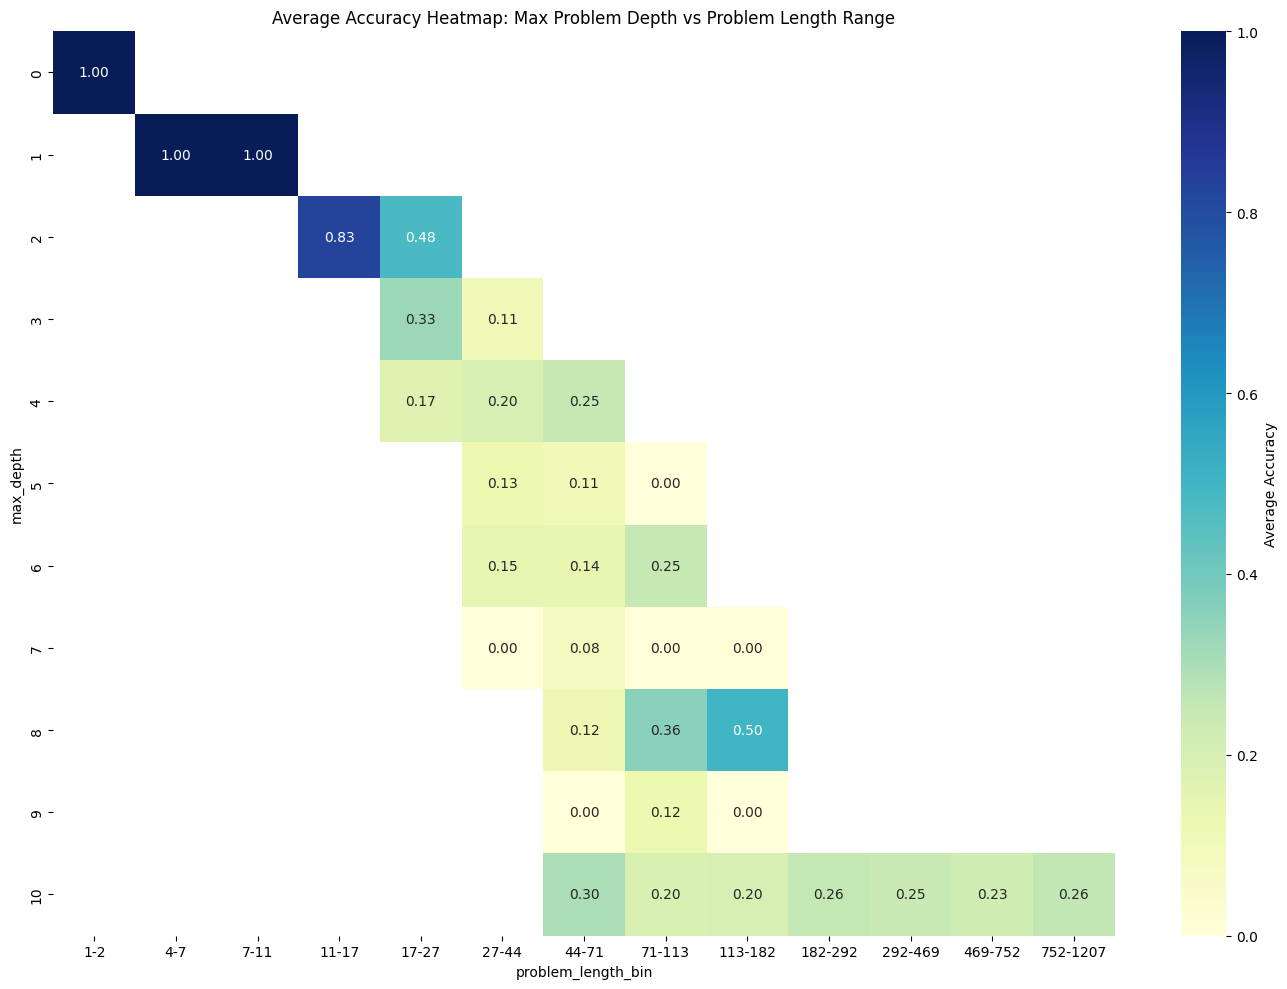

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [210]:
# Rename columns for easier handling
df = df.rename(columns={
    "sample.splits.max_problem_depth": "max_depth",
    "sample.splits.problem_length": "problem_length"
})

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_50890/239383926.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['max_depth', 'problem_length_bin'])['score'].mean().reset_index()
/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_50890/239383926.py:32: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = grouped_df.pivot_table(values="score", index="max_depth", columns="problem_length_bin", aggfunc="mean")


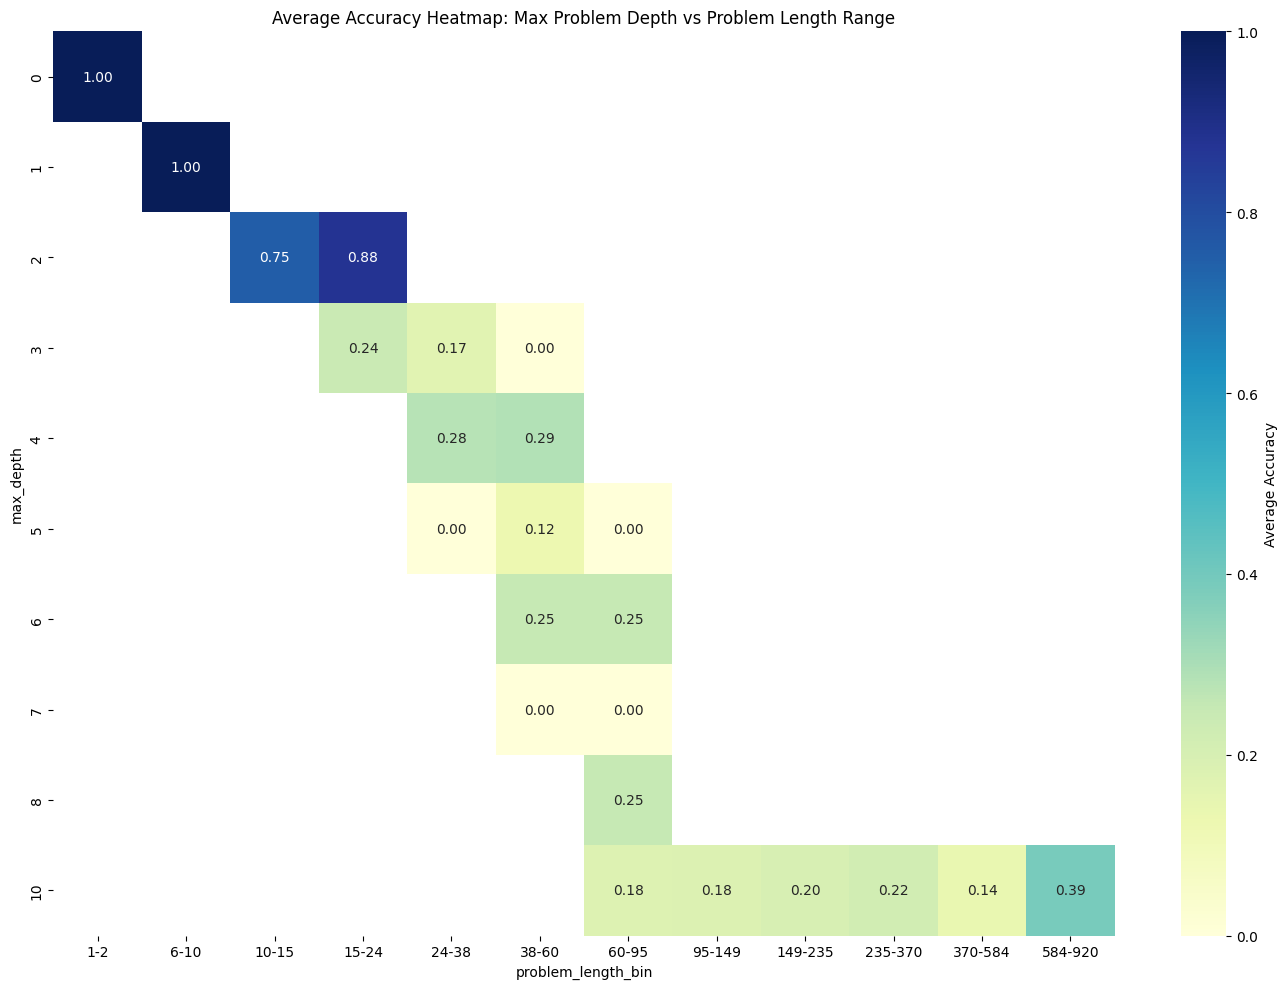

/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_50890/2891220365.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=45, ha='right')


TypeError: 'int' object is not subscriptable

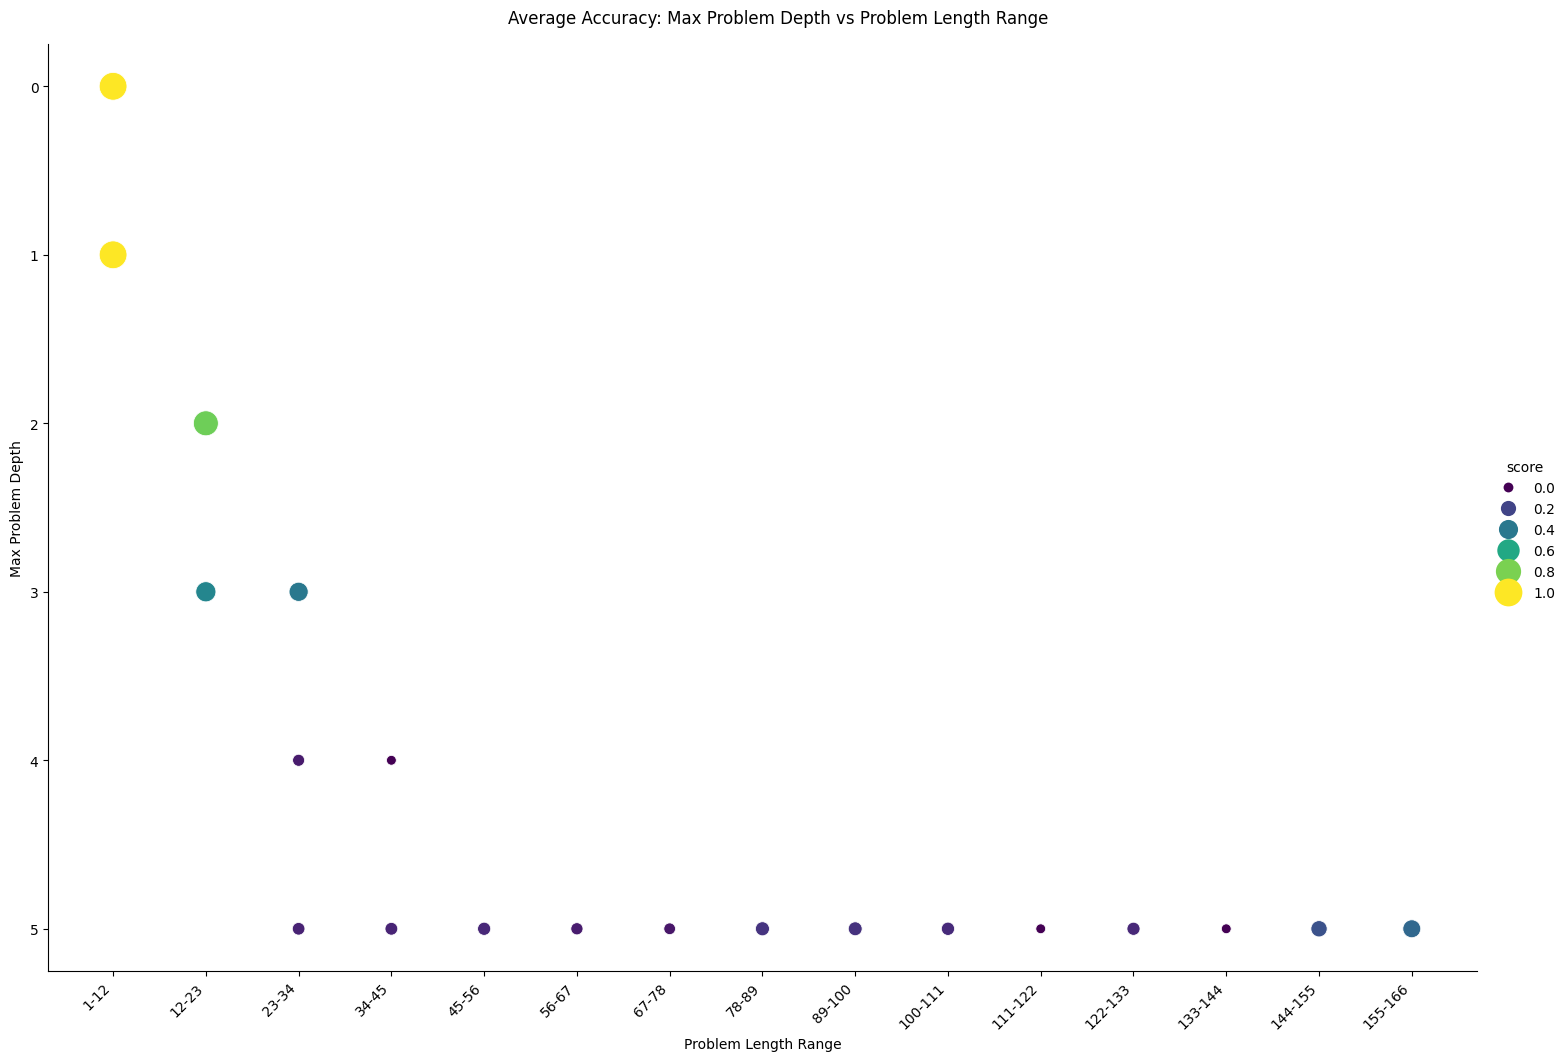

In [204]:
# 2. Seaborn Relplot (replacing 3D surface plot)
g = sns.relplot(
    data=grouped_df,
    x="problem_length_bin", y="max_depth",
    hue="score",
    palette="viridis", sizes=(50, 400),
    height=10, aspect=1.5,
)
g.set(xlabel="Problem Length Range", ylabel="Max Problem Depth")
g.fig.suptitle("Average Accuracy: Max Problem Depth vs Problem Length Range", y=1.02)
g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=45, ha='right')

# Add text annotations for the score
for i, row in grouped_df.iterrows():
    g.ax.text(row.name[1], row.name[0], f'{row.score:.2f}', 
              ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Scatter plot with size indicating average accuracy
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(data=grouped_df, x="problem_length_bin", y="max_depth", size="score", 
                          sizes=(20, 200), hue="score", palette="viridis")
plt.title("Scatter Plot: Max Problem Depth vs Problem Length Range (size/color = Average Accuracy)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Line plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

sns.lineplot(data=grouped_df, x="max_depth", y="score", ax=ax1)
ax1.set_title("Average Accuracy vs Max Problem Depth")
ax1.set_xlabel("Max Problem Depth")
ax1.set_ylabel("Average Accuracy")

sns.lineplot(data=grouped_df, x="problem_length_bin", y="score", ax=ax2)
ax2.set_title("Average Accuracy vs Problem Length Range")
ax2.set_xlabel("Problem Length Range")
ax2.set_ylabel("Average Accuracy")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [140]:
# visualize some results (courtest of claude)
import json
from typing import Dict, List, Any, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Accuracy Pie Chart
def plot_accuracy_pie(total_correct: int, total_incorrect: int) -> None:
    labels: List[str] = ['Correct', 'Incorrect']
    sizes: List[int] = [total_correct, total_incorrect]
    colors: List[str] = ['#66b3ff', '#ff9999']
    
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Accuracy Distribution')
    plt.axis('equal')
    plt.show()

# New function for detailed accuracy breakdown
def plot_detailed_accuracy_pie(total_correct: int, incorrect_and_unparsable: int, incorrect_and_parsable: int) -> None:
    labels: List[str] = ['Correct', 'Incorrect (Unparsable)', 'Incorrect (Parsable)']
    sizes: List[int] = [total_correct, incorrect_and_unparsable, incorrect_and_parsable]
    colors: List[str] = ['#66b3ff', '#ff9999', '#ffcc99']
    
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Detailed Accuracy Distribution')
    plt.axis('equal')
    
    # Add a nested pie chart for incorrect responses
    total_incorrect: int = incorrect_and_unparsable + incorrect_and_parsable
    if total_incorrect > 0:
        inner_sizes: List[float] = [incorrect_and_unparsable / total_incorrect, incorrect_and_parsable / total_incorrect]
        inner_colors: List[str] = ['#ff9999', '#ffcc99']
        plt.pie([0, 1], radius=0.7, colors=['white', 'white'], startangle=90)
        plt.pie(inner_sizes, radius=0.7, colors=inner_colors, startangle=90)
    
    plt.show()

# 2. Confusion Matrix Heatmap
def plot_confusion_heatmap(confusion_table: Dict[str, Dict[str, int]]) -> None:
    df: pd.DataFrame = pd.DataFrame(confusion_table).fillna(0)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Model Output')
    plt.ylabel('Ground Truth')
    plt.show()

# 3. Sample Results Bar Chart
def plot_sample_results(sample_results: List[Dict[str, Any]]) -> None:
    correct: List[int] = [1 if result['output_parsed'] == result['output_correct'] else 0 for result in sample_results]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(correct)), correct, color=['green' if c else 'red' for c in correct])
    plt.title('Sample Results')
    plt.xlabel('Sample Index')
    plt.ylabel('Correct (1) / Incorrect (0)')
    plt.ylim(0, 1.2)
    plt.show()

# 4. Error Analysis
def analyze_errors(sample_results: List[Dict[str, Any]]) -> None:
    errors: List[Dict[str, Any]] = [result for result in sample_results if result['output_parsed'] != result['output_correct']]
    
    print("Error Analysis:")
    for i, error in enumerate(errors, 1):
        print(f"\nError {i}:")
        print(f"Problem: {error['sample']['body'][1]['content']}")
        print(f"Expected: {error['output_correct']}")
        print(f"Model Output: {error['output_parsed']}")

# Updated main function to include the new visualization
def visualize_results(data: Dict[str, Any]) -> None:
    counts: Dict[str, int] = data['counts']
    plot_accuracy_pie(counts['total_correct'], counts['total_incorrect'])
    plot_detailed_accuracy_pie(
        counts['total_correct'],
        counts['incorrect_and_unparsable'],
        counts['incorrect_and_parsable']
    )
    if data['confusion_table']:
        plot_confusion_heatmap(data['confusion_table'])
    plot_sample_results(data['sample_results'])
    analyze_errors(data['sample_results'])

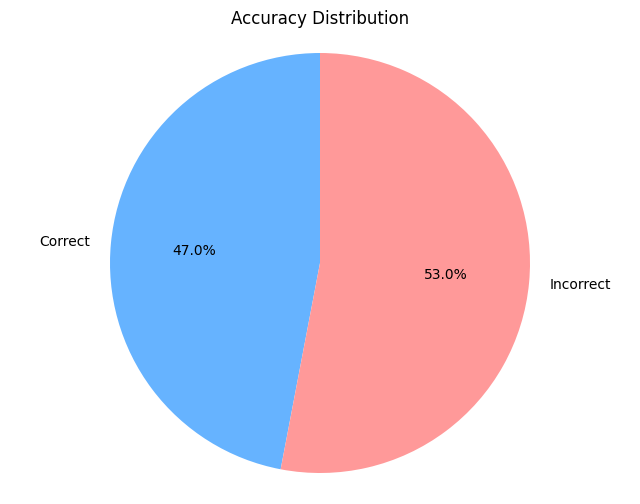

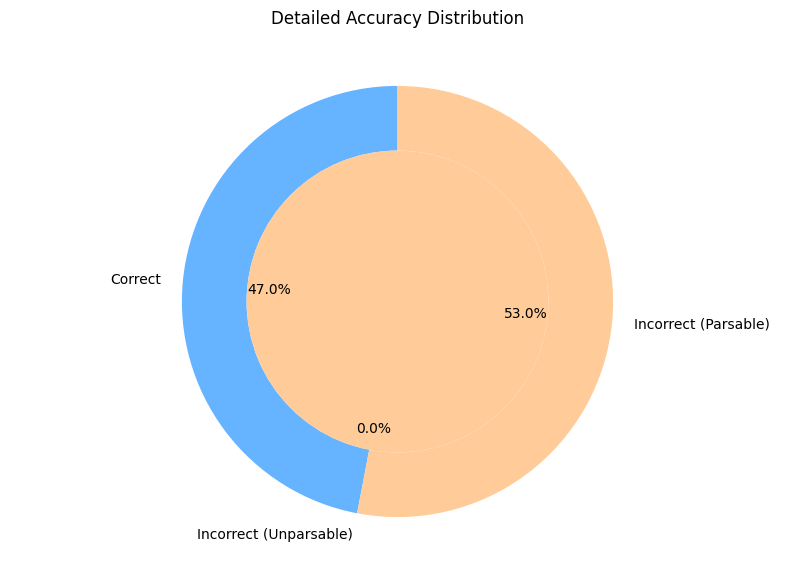

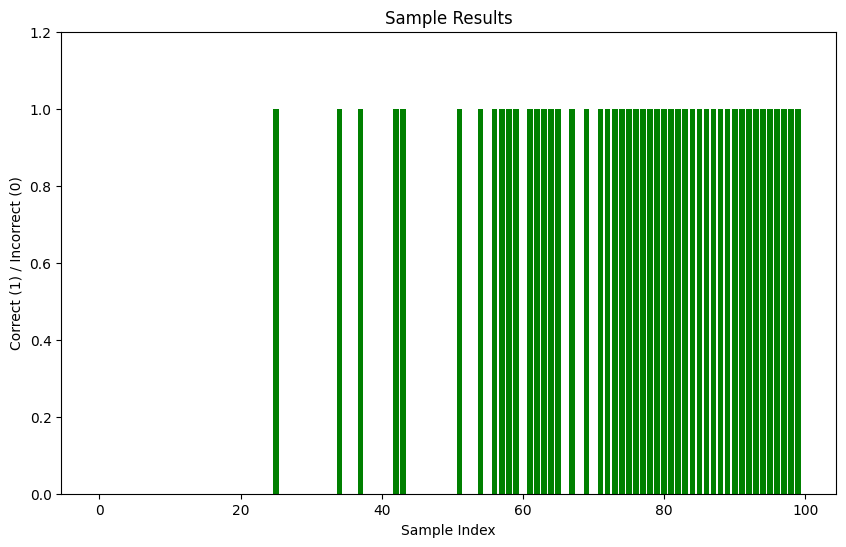

Error Analysis:

Error 1:
Problem: Problem: (((((1 * 6) ** 2) + ((6 + 9) - (1 * 7))) - 2) ** 3)
Expected: 74088
Model Output: 729.0

Error 2:
Problem: Problem: (((((1 ** 4) ** 4) / (5 * (6 * 6))) * 3) ** 4)
Expected: 7.71604938271605e-08
Model Output: 0.0

Error 3:
Problem: Problem: (((((1 + 2) - 3) - ((7 / 10) / (5 ** 4))) ** 2) ** 4)
Expected: 2.475963176294808e-24
Model Output: 0.0

Error 4:
Problem: Problem: (((((10 ** 2) * 3) + ((6 ** 3) ** 2)) - 6) * (4 * (8 + ((8 - 9) ** 2))))
Expected: 1690200
Model Output: 1000000.0

Error 5:
Problem: Problem: (((((2 / 4) - (10 * 5)) / (7 * 10)) / (((4 * 10) / (4 - 10)) + 3)) * ((6 / ((7 * 3) + 9)) + (((8 * 5) * (2 * 8)) * ((7 - 9) - (1 / 5)))))
Expected: -271.50428571428574
Model Output: -0.0

Error 6:
Problem: Problem: (((((4 - 2) + (7 ** 4)) + ((7 - 1) - 6)) - ((2 - (8 + 4)) / 8)) * (4 - (((7 ** 4) * (6 ** 2)) * 5)))
Expected: -1039059148.0
Model Output: -1680000.0

Error 7:
Problem: Problem: (((((5 * 10) * (9 * 1)) - (7 - (8 - 8))) / (4 + 

In [141]:
eval_result_json_dict = eval_result.model_dump()

visualize_results(eval_result_json_dict)

Generating samples...
Encountered: <class 'ZeroDivisionError'> during problem generation for problem ((7 * (6 / ((5 * ((((7 / (7 - 7)) * ((1 - 3) * 6)) / 8) ** 2)) ** 4))) / ((7 ** 2) * 5)), attempting again
Invalid solution: -2.534753973271453e+119 for (3 - ((9 - ((2 + (((6 + (5 + 6)) + 7) ** 2)) * ((10 * 9) - ((((10 ** 3) * 8) - (((4 ** 4) ** 4) + 5)) / ((((8 / 9) - (5 + 1)) - ((4 / 1) / (8 + 2))) * ((9 + (8 + 4)) - ((2 + 6) ** 2))))))) + ((((((((4 + 6) ** 3) - 3) ** 3) * 9) ** 4) + 1) ** 3))), attempting again
Invalid solution: 2.1724371872722345e+27 for ((((6 ** 4) * ((((((4 / (8 + 5)) / ((3 ** 2) - 2)) + 8) ** 4) / (((((3 - 2) ** 4) + 1) / (((6 + 10) ** 3) / 10)) ** 3)) + (8 ** 2))) - (4 ** 2)) ** 2), attempting again
Invalid solution: -81501360837394.19 for (((9 ** 3) / 5) + (6 - (((((((8 / 8) - ((2 / 2) - 1)) + (4 + (2 / (6 * 2)))) ** 4) ** 4) + 2) * ((((8 - ((2 / 2) + (4 - (4 + 6)))) + (8 * (10 * 10))) - 6) * ((2 * ((((9 * 1) + (5 * 6)) + 3) * (((2 / 7) ** 2) ** 4))) * ((3 * ((

100%|██████████| 1000/1000 [00:47<00:00, 21.01it/s]
/Users/bronsonschoen/gpt_from_scratch/gpt_from_scratch/evals/arithmetic_eval/visualization.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["max_depth", "problem_length_bin"])["score"].mean().reset_index()
/Users/bronsonschoen/gpt_from_scratch/gpt_from_scratch/evals/arithmetic_eval/visualization.py:62: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = grouped_df.pivot_table(


Eval complete, converting results to output format...
Completed eval of 1000 samples


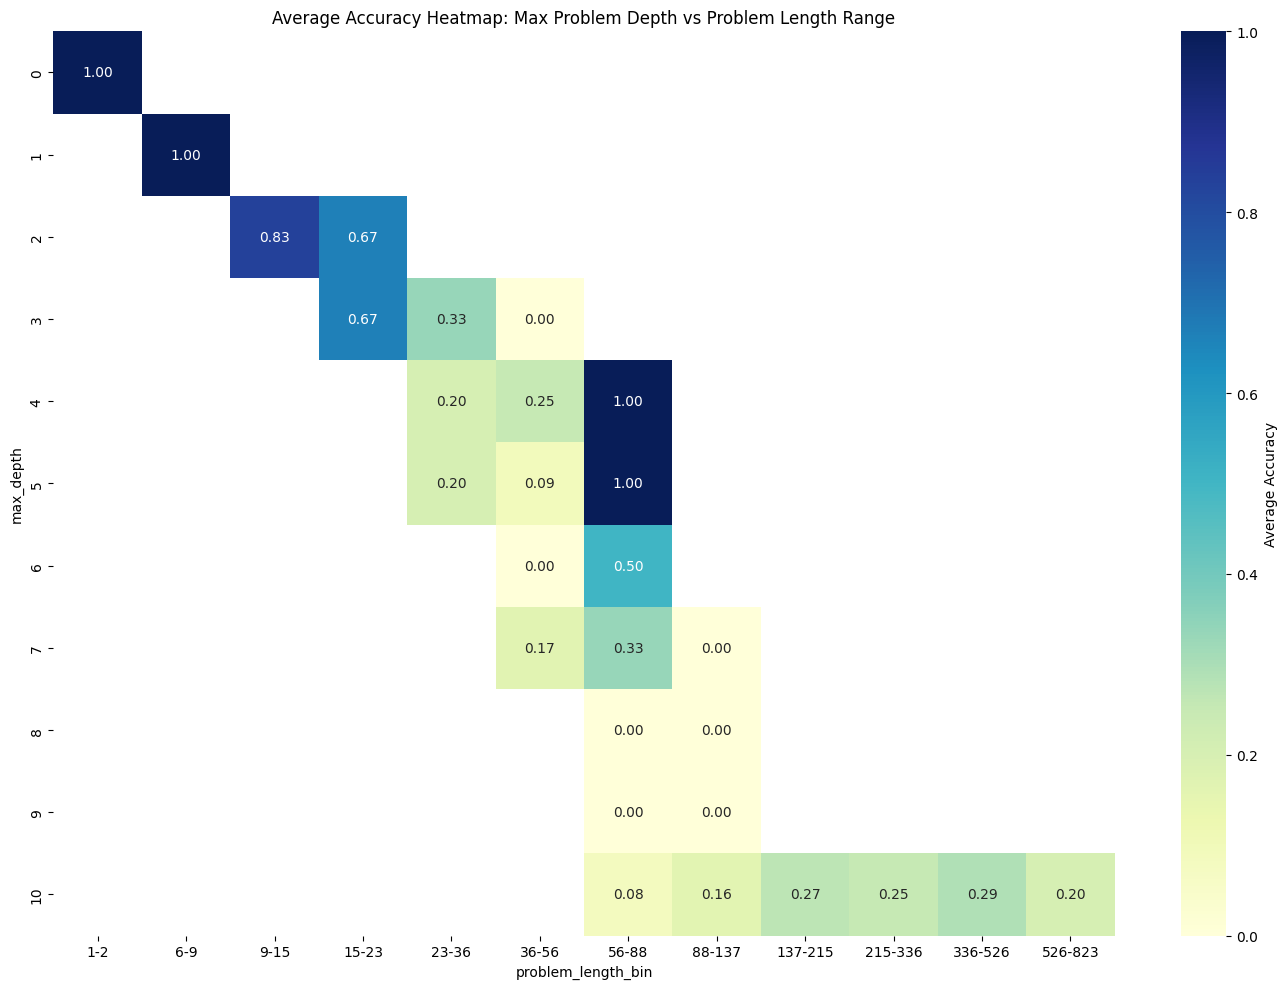

In [222]:
from gpt_from_scratch.evals.arithmetic_eval import (
  arithmetic_eval,
  visualization,
)

# note: Returns json normalized `evalugator.evals.EvalResult`
df = arithmetic_eval.create_and_run_eval(
  model='gpt-4o',
  max_depth=10,
  num_problems=1000,
)

visualization.plot_heatmap(df)